# Best Options to Invest

## 1. Exploratory Data Analysis

### 1.1. Location Data

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy.spatial.distance import cdist

from sklearn import preprocessing
from sklearn.cluster import KMeans

import folium

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# downloading the data in csv format
! wget -q -O 'ca_counties_location.csv' https://data.edd.ca.gov/api/views/bpwh-bcb3/rows.csv?accessType=DOWNLOAD

ca_counties_df = pd.read_csv('ca_counties_location.csv')
ca_counties_df.head()

,Latitude,the_geom,Name,Longitude
0,41.743438,MULTIPOLYGON (((-124.21284783991833 41.8708173...,Del Norte,-123.896950
1,41.592777,MULTIPOLYGON (((-123.51814169611895 42.0011639...,Siskiyou,-122.540597
2,41.589786,MULTIPOLYGON (((-121.44763489811575 41.9973336...,Modoc,-120.725183
3,40.698631,MULTIPOLYGON (((-124.06516973640174 41.4645760...,Humboldt,-123.873714
4,40.650636,MULTIPOLYGON (((-122.67701482828117 41.2803710...,Trinity,-123.112688


In [3]:
# dropping the unnecessary column
ca_counties = ca_counties_df.drop('the_geom', axis=1)

# renaming a coulumn
ca_counties.rename(columns={'Name': 'County'}, inplace=True)

ca_counties.head()

,Latitude,County,Longitude
0,41.743438,Del Norte,-123.896950
1,41.592777,Siskiyou,-122.540597
2,41.589786,Modoc,-120.725183
3,40.698631,Humboldt,-123.873714
4,40.650636,Trinity,-123.112688


In [4]:
ca_counties.shape

(58, 3)

As expected, there are 58 rows in the counties' location dataframe.

A Map of the counties of California.

In [5]:
# generating a map of California

map_ca = folium.Map(location=[34.36159, -118.21698], zoom_start=6)

# add markers to map
for lat, lng, county in zip(ca_counties['Latitude'], ca_counties['Longitude'], ca_counties['County']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#350091',
        fill=True,
        fill_color='#5e03fc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ca)
    
map_ca

### 1.2. Population Data

In [6]:
! wget -q -O 'ca_counties_population.csv' https://www.dropbox.com/s/rdi7kebqo9dxq5r/ca_population.csv?dl=1

In [7]:
population_df = pd.read_csv('ca_counties_population.csv')
population_df.head()

,County,Population
0,".Alameda County, California",1671329
1,".Alpine County, California",1129
2,".Amador County, California",39752
3,".Butte County, California",219186
4,".Calaveras County, California",45905


In [8]:
population_df['County'] = population_df['County'].apply(lambda x: x.replace(" County, California", ""))
population_df['County'] = population_df['County'].apply(lambda x: x.replace(".", ""))

In [9]:
population_df.dtypes

County        object
Population     int64
dtype: object

In [10]:
population_df.head()

,County,Population
0,Alameda,1671329
1,Alpine,1129
2,Amador,39752
3,Butte,219186
4,Calaveras,45905


A graph of Population vs. The Counties of California

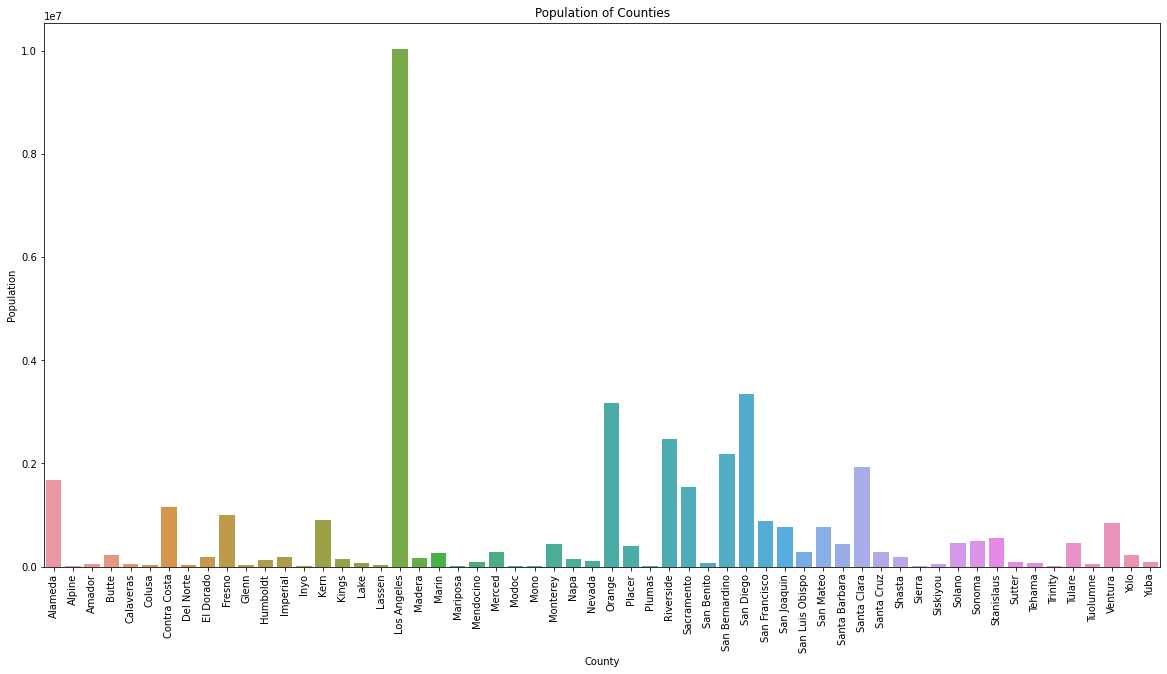

In [11]:
figure, ax = plt.subplots(figsize=(20,10))
pop_bplot = sns.barplot(x='County', y='Population', ax=ax, data=population_df)
pop_bplot.set_xticklabels(population_df['County'], rotation=90)
pop_bplot.set_title('Population of Counties')
pop_bplot

We can see, there is a high variance in data, and we need to be aware of this.


In [12]:
var_in_pop = np.var(population_df['Population'])
var_in_pop

2117672097592.2085

### 1.3. Real GDP Data

#### 1.3.1. Obtaining Data

In [13]:
! wget -q -O 'ca_counties_gdp.csv' https://www.dropbox.com/s/hlbrcmoksxshc6k/ca_real_gdp.csv?dl=1

In [14]:
gdp_df = pd.read_csv('ca_counties_gdp.csv')
gdp_df.rename(columns={'county': 'County', 'real_gdp': 'Real_GDP'}, inplace=True)
gdp_df.head()

,County,Real_GDP
0,Alameda,130701879
1,Alpine,214895
2,Amador,1651760
3,Butte,9219915
4,Calaveras,1440250


In [15]:
print(gdp_df.shape)

(58, 2)


Getting a sense of GDP of different counties by plotting graph.

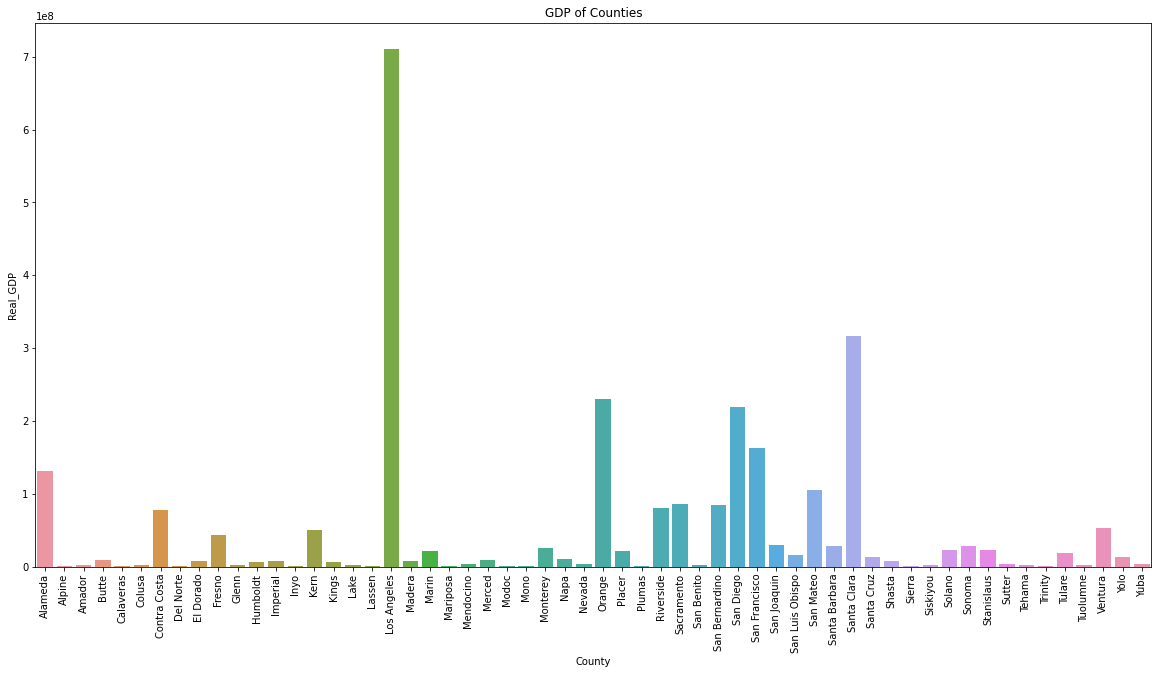

In [16]:
figure, ax = plt.subplots(figsize=(20,10))
gdp_bplot = sns.barplot(x='County', y='Real_GDP', ax=ax, data=gdp_df)
gdp_bplot.set_xticklabels(gdp_df['County'], rotation=90)
gdp_bplot.set_title('GDP of Counties')
gdp_bplot

#### 1.3.2 Forming a unified dataframe with Location Data, GDP Data and Population Data

In [17]:
ca_counties_gdp_pop = population_df.merge(gdp_df, on='County')
print(ca_counties_gdp_pop.shape)
ca_counties_gdp_pop.head()

(58, 3)


,County,Population,Real_GDP
0,Alameda,1671329,130701879
1,Alpine,1129,214895
2,Amador,39752,1651760
3,Butte,219186,9219915
4,Calaveras,45905,1440250


In [18]:
ca_counties_df = ca_counties_gdp_pop.merge(ca_counties, on='County')
ca_counties_df.head()

,County,Population,Real_GDP,Latitude,Longitude
0,Alameda,1671329,130701879,37.644874,-121.882289
1,Alpine,1129,214895,38.597971,-119.820211
2,Amador,39752,1651760,38.446117,-120.651572
3,Butte,219186,9219915,39.667011,-121.600718
4,Calaveras,45905,1440250,38.205015,-120.553757


In [19]:
ca_counties_df.shape

(58, 5)

#### 1.3.3. Correlation Between GDP and Economy of a County

I would like to argue that a county with higher economical prosperity is very likely to be a county with high population. Furthermore, a county with high population **or** high GDP is a good investment destination for a new eatery.

I will use the [Pearson Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) for calculating the correlation.



In [20]:
# using the pearsonr method from SciPy Stats to calculate correlation index and the p-value

pearson_coef, pval = pearsonr(ca_counties_df['Population'], ca_counties_df['Real_GDP'])

print(f'Pearson Coefficient: {pearson_coef}')
print(f'p-value: {pval}')

Pearson Coefficient: 0.9525329968924966
p-value: 1.3243143990069818e-30


The Pearson Coefficient is about $0.952$ which is very close to $+1$ and suggests a very strong correlation between counties' GDPs and Populations.

The p-value is $1.32 \times 10^{-30}$ which is extremely low and much much lesser than $0.05$ ( $<<< 0.05$).

So it is safe to conclude that conties with higher population tend to have a higher GDP and are better destinations for new business.

Visualizing the correlation between GDP and Population.


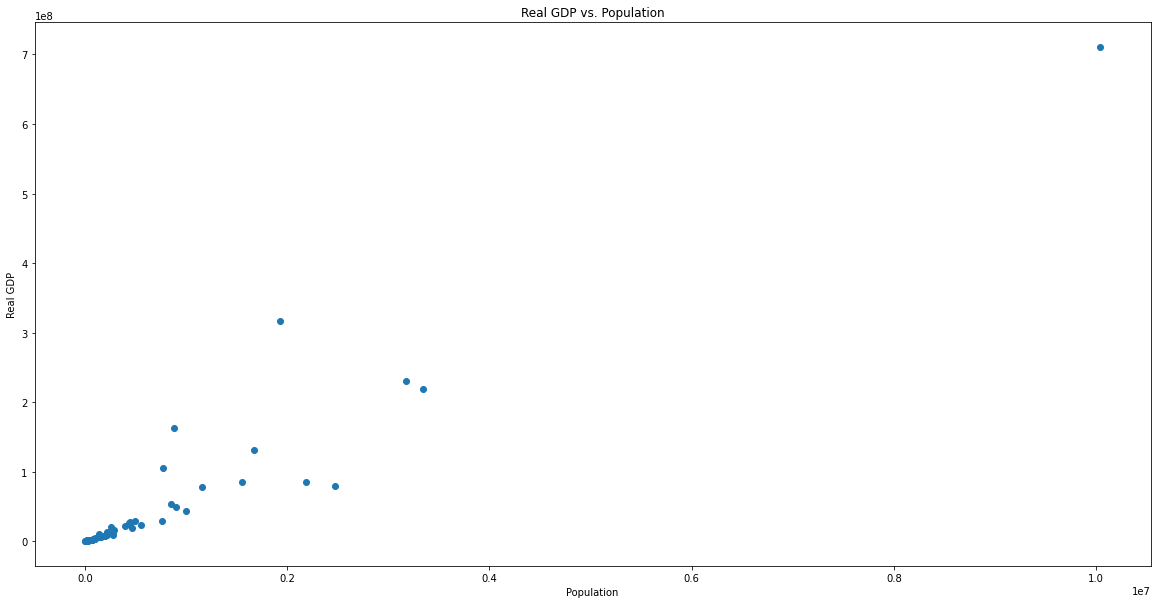

In [21]:
plt.figure(figsize=(20, 10))

plt.scatter(ca_counties_df['Population'], ca_counties_df['Real_GDP'])

plt.xlabel('Population')
plt.ylabel('Real GDP')
plt.title('Real GDP vs. Population')
plt.show()

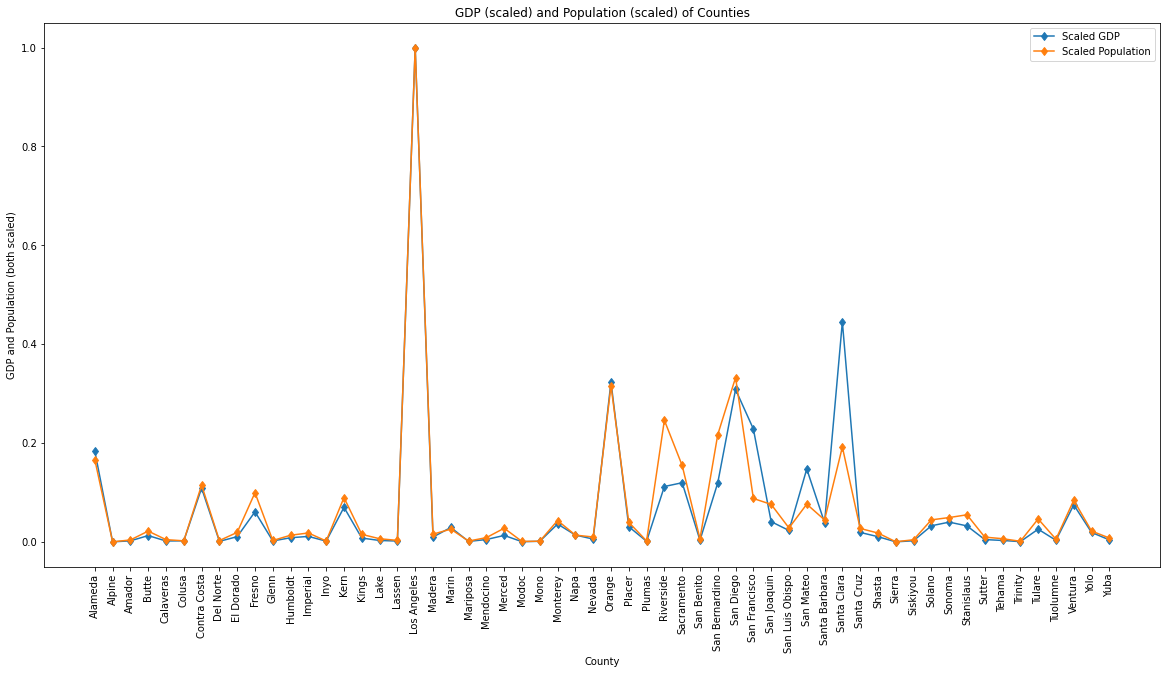

In [22]:
# forming a dataframe consisting of gdp data and population data
plot_ca_df = ca_counties_df[['Real_GDP', 'Population']]

# scaling data
min_max_scaler = preprocessing.MinMaxScaler()
x = plot_ca_df.values
x_scaled = min_max_scaler.fit_transform(x)
plot_ca_df_scaled = pd.DataFrame(x_scaled)
plot_ca_df_scaled.columns = ['scaled_gdp', 'scaled_population']

# plotting data
plt.figure(figsize=(20,10))
gdp_plot = plt.plot(ca_counties_df['County'], plot_ca_df_scaled['scaled_gdp'], 'd-')
population_plot = plt.plot(ca_counties_df['County'], plot_ca_df_scaled['scaled_population'], 'd-')
plt.legend(['Scaled GDP', 'Scaled Population'])
plt.xlabel('County')
plt.ylabel('GDP and Population (both scaled)')
plt.title('GDP (scaled) and Population (scaled) of Counties')
plt.xticks(rotation=90)

plt.show()

### 1.4. Foursquare Data

Client ID and Client Secret has been stored in two variables `client_id` and `client_secret`. The code cell has been deleted for obvious security reasons.

In [24]:
CLIENT_ID = client_id
CLIENT_SECRET = client_secret
VERSION = '20200101'

Now, I shall call the Foursquare API to provide an outlook of the data.

In [25]:
# choosing the Los Angeles county of California and showing its venues

ca_counties.loc[52, 'County']

'Los Angeles'

In [26]:
# retrieving information about the county from dataframe

county_name = ca_counties.loc[52, 'County']
county_lat = ca_counties.loc[52, 'Latitude']
county_long = ca_counties.loc[52, 'Longitude']

print(f'The {county_name} county\'s latitude is {county_lat} and longitude is {county_long}')

The Los Angeles county's latitude is 34.3615935047 and longitude is -118.21698181100001


Let's see the eateries listed in Foursquare in Los Angeles.

Now let's retrieve the list of venues which are in the vicinity of the center of the county. A list of venues within 10 km will be retrieved.

In [27]:
# getting venues from Foursquare API

RADIUS = 10000
category_id = '4d4b7105d754a06374d81259' # category id for food as provided in Foursquare API documentation
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    county_lat,
    county_long,
    category_id,
    RADIUS,    
)

url

'https://api.foursquare.com/v2/venues/search?&client_id=LNBN1GEEE0442WVW4EBRG2AP2M5D2INS422JHZVKSZ0WOM0V&client_secret=EJ1DEZ5HCP3I05RNZ4GZYOUKWGSNYPP30UF4RPIIW3EH45RR&v=20200101&ll=34.3615935047,-118.21698181100001&categoryId=4d4b7105d754a06374d81259&radius=10000'

In [28]:
results = requests.get(url).json()

In [29]:
results

{'meta': {'code': 200, 'requestId': '5f16cd0efae08831152b2c0e'},
 'response': {'confident': False,
  'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d16e941735',
      'name': 'Fast Food Restaurant',
      'pluralName': 'Fast Food Restaurants',
      'primary': True,
      'shortName': 'Fast Food'}],
    'hasPerk': False,
    'id': '524b221611d2dd0599669584',
    'location': {'address': '2225 Foothill Blvd',
     'cc': 'US',
     'city': 'La Cañada',
     'country': 'United States',
     'distance': 13957,
     'formattedAddress': ['2225 Foothill Blvd',
      'La Cañada, CA 91011',
      'United States'],
     'labeledLatLngs': [{'label': 'display',
       'lat': 34.23850778916528,
       'lng': -118.24592111299677}],
     'lat': 34.23850778916528,
     'lng': -118.24592111299677,
     'postalCode': '91011',
     'state': 'CA'},
    'name': 'Jack in the Box',
    'referralId': '

In [30]:
venues = results['response']['venues']

In [31]:
venues
nearby_venues = pd.json_normalize(venues)
nearby_venues.head(3)

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,524b221611d2dd0599669584,Jack in the Box,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1595330190,False,2225 Foothill Blvd,34.238508,-118.245921,"[{'label': 'display', 'lat': 34.23850778916528...",13957,91011,US,La Cañada,CA,United States,"[2225 Foothill Blvd, La Cañada, CA 91011, Unit..."
1,4fc2d02be4b021b6e05b532e,In N' Out Burger,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",v-1595330190,False,NaN,34.240134,-118.241480,"[{'label': 'display', 'lat': 34.240134, 'lng':...",13707,91214,US,La Crescenta,CA,United States,"[La Crescenta, CA 91214, United States]"
2,4ee011c20e01452f91ee0d76,Wences Bistro,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1595330190,False,"3620 Smith Ave, Acton, CA 93510",34.467690,-118.196388,"[{'label': 'display', 'lat': 34.46768951416015...",11960,93510,US,Acton,CA,United States,"[3620 Smith Ave, Acton, CA 93510, Acton, CA 93..."


In [32]:
# generating a map of Los Angeles

map_la = folium.Map(location=[34.36159, -118.21698], zoom_start=12)

# add markers to map
for lat, lng, county in zip(nearby_venues['location.lat'], nearby_venues['location.lng'], nearby_venues['name']):
    label = '{}'.format(county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#350091',
        fill=True,
        fill_color='#5e03fc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)
    
map_la

In [33]:
nearby_venues.shape

(8, 16)

In [34]:
# defining function to extract category from the row 'categories' in the nearby_venues dataframe

def get_category(entry):
  return entry[0]['name']

In [35]:
# forming a clean dataframe

# keeping only relevant columns and truncating the rest
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# getting relevant information from categories
nearby_venues['categories'] = nearby_venues['categories'].apply(get_category)

# renaming columns
nearby_venues.rename(columns={
                        'categories': 'category',
                        'location.lat': 'latitude',
                        'location.lng': 'longitude'
}, inplace=True)

nearby_venues.head()

,name,category,latitude,longitude
0,Jack in the Box,Fast Food Restaurant,34.238508,-118.245921
1,In N' Out Burger,Food Court,34.240134,-118.241480
2,Wences Bistro,Café,34.467690,-118.196388
3,Funnel Cake Stand,Dessert Shop,34.261764,-118.299381
4,Duner's Diner,Burger Joint,34.283105,-118.147541


Now, a function will be built for a repeating the same process for all the counties in California.

In [36]:
def get_nearby_venues(names, latitudes, longitudes, gdps, populations, radius=10000):
  venues_list = []
  category_id = '4d4b7105d754a06374d81259'
  for name, lat, lng, gdp, pop in zip(names, latitudes, longitudes, gdps, populations):
    # print(name + ' county\'s venues are being added to the list.') TESTD OK

    # form the URL for API call
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius=10000&limit=50'.format(
              CLIENT_ID, 
              CLIENT_SECRET, 
              VERSION, 
              lat, 
              lng,
              category_id)
    # print(url) #TESTED OK
  
    # call the API, store the relevant result
    results = requests.get(url).json()
    results = results['response']['venues']
    # print(results) # TESTED OK
    for row in results:
      if (results):
        venues_list.append([(name,
                            lat,
                            lng,
                            gdp,
                            pop,
                            row['name'],
                            row['categories'][0]['name'],
                            row['location']['lat'],
                            row['location']['lng'])])
      else:
        venues_list.append([(name,
                             lat,
                             lng,
                             gdp,
                             pop,
                             0,
                             0,
                             0,
                             0)])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])


  nearby_venues.columns = ['county',
                           'county_latitude',
                           'county_longitude',
                           'county_gdp',
                           'county_pop',
                           'name',
                           'category',
                           'venue_latitude',
                           'venue_longitude']
    
  return(nearby_venues)

In [37]:
california_venues = get_nearby_venues(ca_counties_df['County'], latitudes=ca_counties_df['Latitude'], longitudes=ca_counties_df['Longitude'], gdps=ca_counties_df['Real_GDP'], populations=ca_counties_df['Population'])

In [38]:
california_venues['county_gdp'] = california_venues['county_gdp'].astype('float')
california_venues['county_pop'] = california_venues['county_pop'].astype('float')

In [39]:
california_venues.dtypes

county               object
county_latitude     float64
county_longitude    float64
county_gdp          float64
county_pop          float64
name                 object
category             object
venue_latitude      float64
venue_longitude     float64
dtype: object

In [40]:
california_venues.head()

,county,county_latitude,county_longitude,county_gdp,county_pop,name,category,venue_latitude,venue_longitude
0,Alameda,37.644874,-121.882289,130701879.0,1671329.0,Heritage Donut Shop,Donut Shop,37.650475,-121.880030
1,Alameda,37.644874,-121.882289,130701879.0,1671329.0,McDonald's,Fast Food Restaurant,37.700653,-121.871454
2,Alameda,37.644874,-121.882289,130701879.0,1671329.0,Starbucks,Coffee Shop,37.705820,-121.888660
3,Alameda,37.644874,-121.882289,130701879.0,1671329.0,Castlewood Country Club,Golf Course,37.637042,-121.894856
4,Alameda,37.644874,-121.882289,130701879.0,1671329.0,The Coffee Co.,Coffee Shop,37.650385,-121.877660


In [41]:
california_venues.shape

(1328, 9)

There are $1329$ unique venues in California City.

## 2. Analysing California's Eateries

### 2.1 Number of Eateries in Each County

In [42]:
california_venues.groupby('county').count()

,county_latitude,county_longitude,county_gdp,county_pop,name,category,venue_latitude,venue_longitude
county,,,,,,,,
Alameda,50,50,50,50,50,50,50,50
Alpine,5,5,5,5,5,5,5,5
Amador,40,40,40,40,40,40,40,40
Butte,18,18,18,18,18,18,18,18
Calaveras,46,46,46,46,46,46,46,46
Colusa,26,26,26,26,26,26,26,26
Contra Costa,50,50,50,50,50,50,50,50
El Dorado,28,28,28,28,28,28,28,28
Fresno,50,50,50,50,50,50,50,50


In [43]:
california_venues.groupby('county').count().shape

(45, 8)

There are 45 rows for which the Foursquare API has returned venues.

In [44]:
# putting county name and total number of eateries in one dataframe
county_no_df = pd.DataFrame(california_venues.groupby('county').count())
# county_no_df = county_no_df[['county', 'name']]
# county_no_df.columns = ['county'] + county_no_df.columns
county_no_df.head()

,county_latitude,county_longitude,county_gdp,county_pop,name,category,venue_latitude,venue_longitude
county,,,,,,,,
Alameda,50,50,50,50,50,50,50,50
Alpine,5,5,5,5,5,5,5,5
Amador,40,40,40,40,40,40,40,40
Butte,18,18,18,18,18,18,18,18
Calaveras,46,46,46,46,46,46,46,46


In [45]:
venues_in_each_county = (california_venues.groupby('county').agg({'name': 'count'})).reset_index()
venues_in_each_county.rename(columns={'name': 'no_of_venues'}, inplace=True)

venues_in_each_county.head()

,county,no_of_venues
0,Alameda,50
1,Alpine,5
2,Amador,40
3,Butte,18
4,Calaveras,46


Plot of number of venues in each county of California

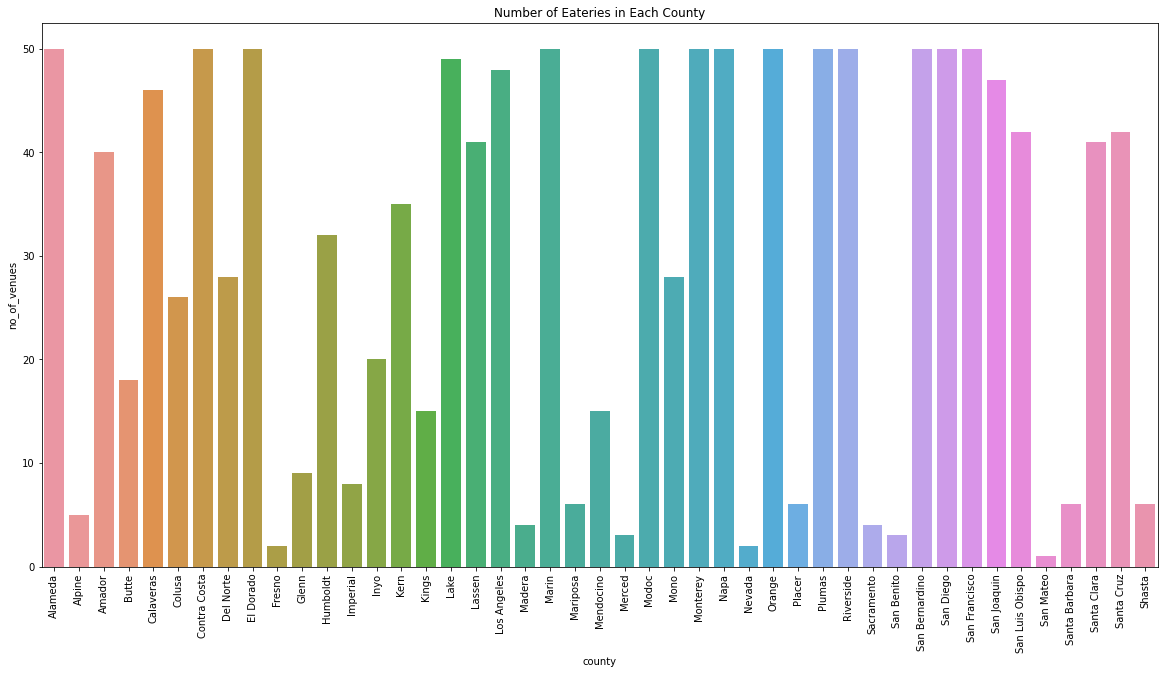

In [46]:
figure, ax = plt.subplots(figsize=(20,10))
eatery_bplot = sns.barplot(x='county', y='no_of_venues', ax=ax, data=venues_in_each_county)
eatery_bplot.set_xticklabels(gdp_df['County'], rotation=90)
eatery_bplot.set_title('Number of Eateries in Each County')
eatery_bplot

In [47]:
print('There are {} uniques categories.'.format(len(california_venues['category'].unique())))

There are 104 uniques categories.


### 2.2. Analysing the Data

In [48]:
# using one hot encoding
california_onehot = pd.get_dummies(california_venues[['category']], prefix="", prefix_sep="")
# adding the columns- county name, real gdp and population to the dataframe with the dummy indices
california_onehot['county'] = california_venues['county']
california_onehot['county_gdp'] = california_venues['county_gdp']
california_onehot['county_pop'] = california_venues['county_pop']
# making the 'county', 'county_gdp', 'county_pop' column as the first coulumn of the dataframe
for i in range(3):
  fixed_columns = [california_onehot.columns[-1]] + list(california_onehot.columns[:-1])
  california_onehot = california_onehot[fixed_columns]

california_onehot.head()

,county,county_gdp,county_pop,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Bistro,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,...,Korean Restaurant,Latin American Restaurant,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Moving Target,New American Restaurant,Noodle House,Peruvian Restaurant,Pizza Place,Pub,Resort,Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Truck Stop,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Wings Joint
0,Alameda,130701879.0,1671329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alameda,130701879.0,1671329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alameda,130701879.0,1671329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alameda,130701879.0,1671329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alameda,130701879.0,1671329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
california_onehot.shape

(1328, 107)

Creating a dataframe with the mean of frequencies of each categories for every county.

In [50]:
california_grouped = california_onehot.groupby('county').mean().reset_index()
california_grouped

,county,county_gdp,county_pop,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Bistro,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,...,Korean Restaurant,Latin American Restaurant,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Moving Target,New American Restaurant,Noodle House,Peruvian Restaurant,Pizza Place,Pub,Resort,Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Truck Stop,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Wings Joint
0,Alameda,130701879.0,1671329.0,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.020000,0.080000,0.000000,0.00,0.02,0.00000,0.000000,0.00,0.06,0.00,0.020000,0.000000,0.00,0.020000,0.00000,0.00,0.000000,0.000000,0.020000,0.00,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,...,0.00,0.00000,0.00,0.000,0.02,0.080000,0.00,0.000000,0.000000,0.020000,0.00,0.00000,0.020000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.020000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Alpine,214895.0,1129.0,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.200000,0.00000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,...,0.00,0.00000,0.00,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.200000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,Amador,1651760.0,39752.0,0.000000,0.150000,0.000000,0.050000,0.000000,0.025000,0.000000,0.125000,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.05,0.050000,0.000000,0.00,0.075000,0.00000,0.00,0.000000,0.000000,0.025000,0.00,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.00,0.00000,0.00,0.025,0.00,0.025000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.175000,0.00,0.000000,0.025000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.025000,0.000000,0.000000,0.000000,0.00,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Butte,9219915.0,219186.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.00,0.00000,0.00,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.166667,0.00,0.000000,0.000000,0.00,0.00,0.111111,0.00,0.000000,0.00,0.00,0.055556,0.000000,0.00,0.000000,0.055556,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Calaveras,1440250.0,45905.0,0.000000,0.021739,0.000000,0.021739,0.000000,0.000000,0.021739,0.043478,0.000000,0.00,0.00,0.00000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.086957,0.00000,0.00,0.000000,0.000000,0.021739,0.00,0.065217,0.000000,0.000000,0.021739,0.021739,0.000000,0.000000,0.000000,0.000000,0.00,0.021739,...,0.00,0.00000,0

We see that this dataframe has only 45 rows. We can say that, there are no listed eateries in the other 5 counties.

Let's see the top five categories of eateries for each county.

In [51]:
num_top_venues = 5

for county in california_grouped['county']:
    print("----"+county+"----")
    temp = california_grouped[california_grouped['county'] == county].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[3:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 4})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alameda----
                  venue  freq
0           Coffee Shop  0.16
1  Fast Food Restaurant  0.14
2                Bakery  0.08
3    Mexican Restaurant  0.08
4        Ice Cream Shop  0.06


----Alpine----
                 venue  freq
0  American Restaurant   0.4
1       Sandwich Place   0.2
2                 Café   0.2
3                Diner   0.2
4               Market   0.0


----Amador----
                 venue   freq
0          Pizza Place  0.175
1  American Restaurant  0.150
2               Bakery  0.125
3                 Café  0.075
4     Asian Restaurant  0.050


----Butte----
                  venue    freq
0  Fast Food Restaurant  0.1667
1   American Restaurant  0.1667
2           Pizza Place  0.1667
3        Sandwich Place  0.1111
4            Food Truck  0.0556


----Calaveras----
                     venue    freq
0       Mexican Restaurant  0.1522
1              Pizza Place  0.0870
2                     Café  0.0870
3  New American Restaurant  0.0652
4            

We will form a dataframe from this data.

In [52]:
def get_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
california_grouped.shape

(45, 107)

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['county']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
counties_venues_sorted = pd.DataFrame(columns=columns)
counties_venues_sorted['county'] = california_grouped['county']

for ind in np.arange(california_grouped.shape[0]):
    counties_venues_sorted.iloc[ind, 1:] = get_common_venues(california_grouped.iloc[ind, :], num_top_venues)

counties_venues_sorted.head()

,county,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Bakery,Bubble Tea Shop,Ice Cream Shop,Donut Shop,Indian Restaurant,American Restaurant,New American Restaurant
1,Alpine,American Restaurant,Sandwich Place,Café,Diner,Wings Joint,Donut Shop,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
2,Amador,Pizza Place,American Restaurant,Bakery,Café,Buffet,Asian Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Market
3,Butte,Pizza Place,American Restaurant,Fast Food Restaurant,Sandwich Place,Supermarket,Coffee Shop,Food Truck,Comfort Food Restaurant,Food Court,Snack Place
4,Calaveras,Mexican Restaurant,Pizza Place,Café,Coffee Shop,New American Restaurant,Bakery,Restaurant,Food,Sandwich Place,Ice Cream Shop


## 3. Applying Machine Learning

### 3.1. Choosing Features

Forming a dataframe with number of eateries, population, and Real GDP of each county.

In [55]:
gdp_df.rename(columns={'County': 'county', 'Real_GDP': 'real_gdp'}, inplace=True)
ca_eateries_gdp = venues_in_each_county.merge(gdp_df, on='county')
ca_eateries_gdp_pop = ca_eateries_gdp.merge(population_df, left_on='county', right_on='County')
ca_eateries_gdp_pop.drop(columns='County', inplace=True)
ca_eateries_gdp_pop.rename(columns={'Population': 'population'}, inplace=True)
ca_eateries_gdp_pop.head()

,county,no_of_venues,real_gdp,population
0,Alameda,50,130701879,1671329
1,Alpine,5,214895,1129
2,Amador,40,1651760,39752
3,Butte,18,9219915,219186
4,Calaveras,46,1440250,45905


In [56]:
# ca_counties_df.drop(columns=['Latitude', 'Longitude'], inplace=True)
ca_counties_df.head()

,County,Population,Real_GDP,Latitude,Longitude
0,Alameda,1671329,130701879,37.644874,-121.882289
1,Alpine,1129,214895,38.597971,-119.820211
2,Amador,39752,1651760,38.446117,-120.651572
3,Butte,219186,9219915,39.667011,-121.600718
4,Calaveras,45905,1440250,38.205015,-120.553757


As there are data which range differently, we need to normalize the data.

In [57]:
min_max_scaler = preprocessing.MinMaxScaler()

In [58]:
ca_counties_df_clustering = ca_counties_df

In [59]:
needed_columns = ['Real_GDP', 'Population']

x = ca_counties_df_clustering[needed_columns].values
x_scaled = min_max_scaler.fit_transform(x)
ca_counties_df_clustering_scaled = pd.DataFrame(x_scaled)
ca_counties_df_clustering_scaled.head()

,0,1
0,0.183609,0.166388
1,0.000000,0.000000
2,0.002022,0.003848
3,0.012671,0.021723
4,0.001724,0.004461


### 3.2. Determining the Best $k$

As I want to apply KMeans Clustering algorithm to this data, I have to determine the best $k$ for this task. And I will use the *elbow method* for this. I will plot the inertia and distortion for the dataset for different values of $k$. And will accept the $k$ for which noise and distortion are the lowest.

In [60]:
california_grouped_scaled_clustering = ca_counties_df_clustering_scaled

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
k_values = range(2,9) 

for k in k_values:
	kmeans_model_test = KMeans(n_clusters=k).fit(california_grouped_scaled_clustering) 
	kmeans_model_test.fit(california_grouped_scaled_clustering)	 
	
	distortions.append(sum(np.min(cdist(california_grouped_scaled_clustering, kmeans_model_test.cluster_centers_, 
					'euclidean'),axis=1)) / california_grouped_scaled_clustering.shape[0]) 
	inertias.append(kmeans_model_test.inertia_) 

	mapping1[k] = sum(np.min(cdist(california_grouped_scaled_clustering, kmeans_model_test.cluster_centers_, 
				'euclidean'),axis=1)) / california_grouped_scaled_clustering.shape[0] 
	mapping2[k] = kmeans_model_test.inertia_ 

Plot of distortion vs. different k values

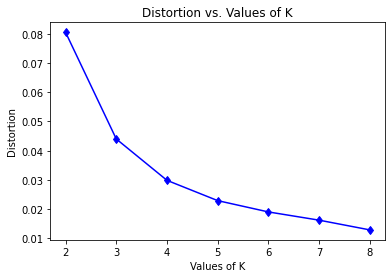

In [61]:
plt.plot(k_values, distortions, 'bd-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Distortion vs. Values of K') 
plt.show()

Plot of inertia vs. different k values

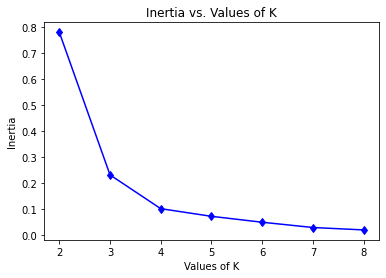

In [62]:
plt.plot(k_values, inertias, 'bd-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('Inertia vs. Values of K') 
plt.show()

We can conclude that $4$ clusters are best suited for this dataset. Above that, data will be overfit.

### 3.3. Applying kMeans Clustering Algorithm

In [63]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4
# california_grouped_scaled_clustering = ca_counties_df_clustering_scaled

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ca_counties_df_clustering_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 0, 0, 0, 0, 3, 0, 0, 3], dtype=int32)

In [64]:
ca_counties_df.rename(columns={'County': 'county',
                                'Population': 'population',
                                'Real_GDP': 'real_gdp',
                                'Latitude': 'latitude',
                                'Longitude': 'longitude'}, inplace=True)
ca_counties_df.head()

,county,population,real_gdp,latitude,longitude
0,Alameda,1671329,130701879,37.644874,-121.882289
1,Alpine,1129,214895,38.597971,-119.820211
2,Amador,39752,1651760,38.446117,-120.651572
3,Butte,219186,9219915,39.667011,-121.600718
4,Calaveras,45905,1440250,38.205015,-120.553757


In [65]:
print(ca_counties_df.shape)
print(counties_venues_sorted.shape)
print(len(kmeans.labels_))
# relevant_counties = [item for item in counties_venues_sorted['county'].values]

# ca_counties_df_relevant = ca_counties_df[relevant_counties]
# ca_counties_df_relevant
# relevant_counties


(58, 5)
(45, 11)
58


In [66]:
counties_venues_sorted.shape
ca_counties_df.insert(0, 'Cluster Labels', kmeans.labels_)

california_merged = ca_counties_df

california_merged = california_merged.merge(counties_venues_sorted, left_on='county', right_on='county', how='right')

california_merged.head() # check the last columns!

,Cluster Labels,county,population,real_gdp,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Alameda,1671329,130701879,37.644874,-121.882289,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Bakery,Bubble Tea Shop,Ice Cream Shop,Donut Shop,Indian Restaurant,American Restaurant,New American Restaurant
1,0,Alpine,1129,214895,38.597971,-119.820211,American Restaurant,Sandwich Place,Café,Diner,Wings Joint,Donut Shop,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
2,0,Amador,39752,1651760,38.446117,-120.651572,Pizza Place,American Restaurant,Bakery,Café,Buffet,Asian Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Market
3,0,Butte,219186,9219915,39.667011,-121.600718,Pizza Place,American Restaurant,Fast Food Restaurant,Sandwich Place,Supermarket,Coffee Shop,Food Truck,Comfort Food Restaurant,Food Court,Snack Place
4,0,Calaveras,45905,1440250,38.205015,-120.553757,Mexican Restaurant,Pizza Place,Café,Coffee Shop,New American Restaurant,Bakery,Restaurant,Food,Sandwich Place,Ice Cream Shop


In [67]:
california_merged = california_merged.dropna()
california_merged.shape

(45, 16)

In [68]:
california_merged.head()

,Cluster Labels,county,population,real_gdp,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Alameda,1671329,130701879,37.644874,-121.882289,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Bakery,Bubble Tea Shop,Ice Cream Shop,Donut Shop,Indian Restaurant,American Restaurant,New American Restaurant
1,0,Alpine,1129,214895,38.597971,-119.820211,American Restaurant,Sandwich Place,Café,Diner,Wings Joint,Donut Shop,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
2,0,Amador,39752,1651760,38.446117,-120.651572,Pizza Place,American Restaurant,Bakery,Café,Buffet,Asian Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Market
3,0,Butte,219186,9219915,39.667011,-121.600718,Pizza Place,American Restaurant,Fast Food Restaurant,Sandwich Place,Supermarket,Coffee Shop,Food Truck,Comfort Food Restaurant,Food Court,Snack Place
4,0,Calaveras,45905,1440250,38.205015,-120.553757,Mexican Restaurant,Pizza Place,Café,Coffee Shop,New American Restaurant,Bakery,Restaurant,Food,Sandwich Place,Ice Cream Shop


In [69]:
# create map
map_clusters = folium.Map(location=[36.7783, -119.4179], zoom_start=5.9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(california_merged['latitude'], california_merged['longitude'], california_merged['county'], california_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### 3.3. Analyzing The Clusters

#### Cluster 1:

In [70]:
cluster_1 = pd.DataFrame(california_merged.loc[california_merged['Cluster Labels'] == 0, california_merged.columns[[0, 1, 2, 3] + list(range(6, california_merged.shape[1]))]])
cluster_1

,Cluster Labels,county,population,real_gdp,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Alpine,1129,214895,American Restaurant,Sandwich Place,Café,Diner,Wings Joint,Donut Shop,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
2,0,Amador,39752,1651760,Pizza Place,American Restaurant,Bakery,Café,Buffet,Asian Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Market
3,0,Butte,219186,9219915,Pizza Place,American Restaurant,Fast Food Restaurant,Sandwich Place,Supermarket,Coffee Shop,Food Truck,Comfort Food Restaurant,Food Court,Snack Place
4,0,Calaveras,45905,1440250,Mexican Restaurant,Pizza Place,Café,Coffee Shop,New American Restaurant,Bakery,Restaurant,Food,Sandwich Place,Ice Cream Shop
5,0,Colusa,21547,1673234,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Sandwich Place,Ice Cream Shop,Pizza Place,Burrito Place,Italian Restaurant,Coffee Shop,Taco Place
7,0,El Dorado,192843,7653908,Food,American Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Daycare,Deli / Bodega,Café,Burger Joint,Fast Food Restaurant
9,0,Glenn,28393,1495087,Cupcake Shop,Snack Place,Wings Joint,Chocolate Shop,Comfort Food Restaurant,Convenience Store,Creperie,Czech Restaurant,Daycare,Deli / Bodega
11,0,Lake,64386,2178663,BBQ Joint,Coffee Shop,Diner,Burger Joint,Pizza Place,Food,Mexican Restaurant,Chinese Restaurant,Peruvian Restaurant,Deli / Bodega
13,0,Madera,157327,7099931,Pizza Place,Restaurant,Steakhouse,Mexican Restaurant,Dessert Shop,Sandwich Place,Italian Restaurant,Burger Joint,Buffet,Fast Food Restaurant
14,0,Marin,258826,20896027,American Restaurant,Pizza Place,Coffee Shop,Indian Restaurant,Bakery,Deli / Bodega,Restaurant,Chinese Restaurant,New American Restaurant,Cheese Shop


#### Cluster 2:


In [71]:
cluster_2 = pd.DataFrame(california_merged.loc[california_merged['Cluster Labels'] == 1, california_merged.columns[[0, 1, 2, 3] + list(range(6, california_merged.shape[1]))]])
cluster_2

,Cluster Labels,county,population,real_gdp,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,1,Los Angeles,10039107,710893266,Fast Food Restaurant,Chinese Restaurant,Café,Food Court,Deli / Bodega,Dessert Shop,Burger Joint,Donut Shop,Creperie,Cupcake Shop


#### Cluster 3:


In [72]:
cluster_3 = pd.DataFrame(california_merged.loc[california_merged['Cluster Labels'] == 2, california_merged.columns[[0, 1, 2, 3] + list(range(6, california_merged.shape[1]))]])
cluster_3


,Cluster Labels,county,population,real_gdp,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,2,Orange,3175692,230145536,Coffee Shop,Fast Food Restaurant,Bubble Tea Shop,Bakery,Grocery Store,Dessert Shop,Donut Shop,American Restaurant,Korean Restaurant,Burger Joint
25,2,San Diego,3338330,219361505,Mexican Restaurant,Coffee Shop,American Restaurant,Bakery,Pizza Place,Restaurant,Diner,Snack Place,Dessert Shop,Deli / Bodega
31,2,Santa Clara,1927852,316525538,Fast Food Restaurant,Coffee Shop,Pizza Place,Bagel Shop,Bakery,Fried Chicken Joint,Vegetarian / Vegan Restaurant,Thai Restaurant,Donut Shop,American Restaurant


#### Cluster 4:


In [73]:
# california_merged.loc[california_merged['Cluster Labels'] == 3, california_merged.columns[[0, 1, 2, 3] + list(range(6, california_merged.shape[1]))]]
cluster_4 = pd.DataFrame(california_merged.loc[california_merged['Cluster Labels'] == 3, california_merged.columns[[0, 1, 2, 3] + list(range(6, california_merged.shape[1]))]])
cluster_4

,Cluster Labels,county,population,real_gdp,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Alameda,1671329,130701879,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Bakery,Bubble Tea Shop,Ice Cream Shop,Donut Shop,Indian Restaurant,American Restaurant,New American Restaurant
6,3,Contra Costa,1153526,77463188,Coffee Shop,Pizza Place,Burger Joint,Fast Food Restaurant,Café,American Restaurant,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Donut Shop
8,3,Fresno,999101,43436946,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,American Restaurant,Chinese Restaurant,Café,Sports Bar,Market,Burrito Place,Sandwich Place
10,3,Kern,900202,49864234,American Restaurant,Pizza Place,Bakery,Sandwich Place,Steakhouse,Indian Restaurant,Asian Restaurant,Food Truck,Diner,Convenience Store
23,3,Riverside,2470546,79775504,Asian Restaurant,Mexican Restaurant,Pizza Place,Wings Joint,Diner,Comfort Food Restaurant,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
24,3,Sacramento,1552058,85235147,Fast Food Restaurant,Coffee Shop,Bubble Tea Shop,Fried Chicken Joint,Asian Restaurant,Burger Joint,Bakery,Dessert Shop,Dim Sum Restaurant,Sandwich Place
26,3,San Francisco,881549,162541244,Coffee Shop,Bakery,Food Court,Donut Shop,Fast Food Restaurant,Grocery Store,Burger Joint,Filipino Restaurant,Sandwich Place,Italian Restaurant
29,3,San Mateo,766573,104986153,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Café,Pizza Place,BBQ Joint,Gastropub,New American Restaurant,American Restaurant,Burger Joint
42,3,Ventura,846006,53439240,Mexican Restaurant,American Restaurant,Italian Restaurant,Pizza Place,Food,Fast Food Restaurant,Sandwich Place,Ice Cream Shop,Snack Place,Café


## 4. Recommendations Outline

In clusters 2, 3 we have counties with high population and high GDP.  In these counties, it will be profitable to invest in any eatery while it is advisable to invest in a eatery which is not in top 3 venues.

In cluster 4, population and GDP of counties are higher than those of the counties in cluster 1, but lower than those of counties in 2 or 3. Investment in these counties is preferred after county in cluster 2 and cluster 3, in that order. Investment should be done in uncommon eateries so that they face lesser competition.

Cluster 1 is dominated by lower population counties. Investment in these counties, should be preferred after investments in counties in clusters 2 or 3 or cluster 4. Investment in most common eateries is not advised at all. Investment in these counties is least advised.



### 4.1. Cluster 1:

In [74]:
cluster_1.loc[:, cluster_1.columns[[0, 1] + list(range(6, cluster_1.shape[1]))]]


,Cluster Labels,county,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Alpine,Café,Diner,Wings Joint,Donut Shop,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
2,0,Amador,Bakery,Café,Buffet,Asian Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Market
3,0,Butte,Fast Food Restaurant,Sandwich Place,Supermarket,Coffee Shop,Food Truck,Comfort Food Restaurant,Food Court,Snack Place
4,0,Calaveras,Café,Coffee Shop,New American Restaurant,Bakery,Restaurant,Food,Sandwich Place,Ice Cream Shop
5,0,Colusa,American Restaurant,Sandwich Place,Ice Cream Shop,Pizza Place,Burrito Place,Italian Restaurant,Coffee Shop,Taco Place
7,0,El Dorado,Pizza Place,Sandwich Place,Breakfast Spot,Daycare,Deli / Bodega,Café,Burger Joint,Fast Food Restaurant
9,0,Glenn,Wings Joint,Chocolate Shop,Comfort Food Restaurant,Convenience Store,Creperie,Czech Restaurant,Daycare,Deli / Bodega
11,0,Lake,Diner,Burger Joint,Pizza Place,Food,Mexican Restaurant,Chinese Restaurant,Peruvian Restaurant,Deli / Bodega
13,0,Madera,Steakhouse,Mexican Restaurant,Dessert Shop,Sandwich Place,Italian Restaurant,Burger Joint,Buffet,Fast Food Restaurant
14,0,Marin,Coffee Shop,Indian Restaurant,Bakery,Deli / Bodega,Restaurant,Chinese Restaurant,New American Restaurant,Cheese Shop


### 4.1. Cluster 2:

In [75]:
cluster_2.loc[:, cluster_2.columns[[0, 1] + list(range(6, cluster_2.shape[1]))]]

,Cluster Labels,county,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,1,Los Angeles,Café,Food Court,Deli / Bodega,Dessert Shop,Burger Joint,Donut Shop,Creperie,Cupcake Shop


### 4.3. Cluster 3:

In [76]:
cluster_3.loc[:, cluster_3.columns[[0, 1] + list(range(6, cluster_3.shape[1]))]]

,Cluster Labels,county,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,2,Orange,Bubble Tea Shop,Bakery,Grocery Store,Dessert Shop,Donut Shop,American Restaurant,Korean Restaurant,Burger Joint
25,2,San Diego,American Restaurant,Bakery,Pizza Place,Restaurant,Diner,Snack Place,Dessert Shop,Deli / Bodega
31,2,Santa Clara,Pizza Place,Bagel Shop,Bakery,Fried Chicken Joint,Vegetarian / Vegan Restaurant,Thai Restaurant,Donut Shop,American Restaurant


### 4.4. Cluster 4:

In [77]:
cluster_4.loc[:, cluster_4.columns[[0, 1] + list(range(6, cluster_4.shape[1]))]]

,Cluster Labels,county,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Alameda,Mexican Restaurant,Bakery,Bubble Tea Shop,Ice Cream Shop,Donut Shop,Indian Restaurant,American Restaurant,New American Restaurant
6,3,Contra Costa,Burger Joint,Fast Food Restaurant,Café,American Restaurant,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Donut Shop
8,3,Fresno,Mexican Restaurant,American Restaurant,Chinese Restaurant,Café,Sports Bar,Market,Burrito Place,Sandwich Place
10,3,Kern,Bakery,Sandwich Place,Steakhouse,Indian Restaurant,Asian Restaurant,Food Truck,Diner,Convenience Store
23,3,Riverside,Pizza Place,Wings Joint,Diner,Comfort Food Restaurant,Convenience Store,Creperie,Cupcake Shop,Czech Restaurant
24,3,Sacramento,Bubble Tea Shop,Fried Chicken Joint,Asian Restaurant,Burger Joint,Bakery,Dessert Shop,Dim Sum Restaurant,Sandwich Place
26,3,San Francisco,Food Court,Donut Shop,Fast Food Restaurant,Grocery Store,Burger Joint,Filipino Restaurant,Sandwich Place,Italian Restaurant
29,3,San Mateo,Fast Food Restaurant,Café,Pizza Place,BBQ Joint,Gastropub,New American Restaurant,American Restaurant,Burger Joint
42,3,Ventura,Italian Restaurant,Pizza Place,Food,Fast Food Restaurant,Sandwich Place,Ice Cream Shop,Snack Place,Café
